This file is part of the noisy feature remediation pipeline and its primary purpose is to pare down the original feature set to an unocorrelated highly predictive subset of the original features.
We accomplish this by following the method below:
1. Open the pre-featurized Materials Project Formation Energy dataset
2. Use Pearson correlation to drop heavily correlated features (>0.7)
*leaving 88 total features w/current cut-off*
3. Inject a Random Feature sampled from a normal distribution into the feature set
4. Train a RFR Formation Energy prediction model and extract Permutation Feature importance rankings
*Note for 3 - hyperparameters are optmized for the 88 using a single random seed features in model_hyperparameter_tuning.ipynb*
5. For the RFR model remove any feature with a feature importance ranking lower than or equal to the random feature.
6. Train a XGB Formation Energy prediction model and extract Permutation Feature importance rankings
*Note for 4 - hyperparameters are optmized for the 88 using a single random seed features in model_hyperparameter_tuning.ipynb*
7. For the XGB model remove any feature with a feature importance ranking lower than or equal to the random feature.
8. Combine the remaining features from the downselected feature set for XGB and RFR
9. Retrain RFR model and check for performance degradation
10. Retrain the XGB model and check for performance degradation
* We are pragmatists, if the model degrades no more than 10% from the baseline model*
11. Save a file with the downselected features for subsequent notebooks

In [1]:
# import libraries
import os
import zipfile
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
import requests # for making HTTP request, used for downloading data from the website

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score, mean_squared_error

# set random seed to keep the results consistent
random_state = 42
np.random.seed(random_state)

# set the number of features to extract from each model
n_features = 40

%config InlineBackend.figure_formats = ['retina']

# Get ground truth data

In [2]:
# define the function to download the DFT Formation Energy data from Materials Project
# Beware of standardizing the entire X if you are going to do Cross-Validation later on as it will cause information leakage across folds

def get_materials_data(dataset='dft_3d',standardized=False,target='formation_energy_peratom'):
    # zip file name
    zip_file = f'X_{dataset}.csv.zip'
    csv_file = f'X_{dataset}.csv'

    # link
    link = f'https://zenodo.org/records/7659269/files/{zip_file}?download=1'

    # download if zip file does not exist
    if not os.path.exists(zip_file):
        response = requests.get(link, stream=True)
        with open(zip_file, 'wb') as fd:
            for chunk in response.iter_content(chunk_size=128):
                fd.write(chunk)

    # unzip if csv file does not exist
    if not os.path.exists(csv_file):
        with zipfile.ZipFile(zip_file, 'r') as zip_ref:
            zip_ref.extractall('.')

    # load csv
    df = pd.read_csv(csv_file,index_col=0).set_index('jid')

    # modified
    feature_labels = df.columns[-273:].tolist()
    df = df[feature_labels+[target]].dropna()
    X, y = df[feature_labels], df[target]

    if standardized:
        X = StandardScaler().fit_transform(X)
        X = pd.DataFrame(X,index=y.index,columns=feature_labels)

    return feature_labels, X, y, df

In [3]:
feature_labels, X, y, df = get_materials_data()

C:\Users\saraq\AppData\Local\Temp\ipykernel_20492\759178475.py:25: DtypeWarning: Columns (10,14,17,26,30,63) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_file,index_col=0).set_index('jid')


In [4]:
# save X into a csv file
X.to_csv('X_formation_energy.csv')

# save y into a csv file
y.to_csv('y_formation_energy.csv')

In [5]:
X.head()

,minimum CN_VoronoiNN,maximum CN_VoronoiNN,range CN_VoronoiNN,mean CN_VoronoiNN,avg_dev CN_VoronoiNN,minimum local difference in Number,maximum local difference in Number,range local difference in Number,mean local difference in Number,avg_dev local difference in Number,...,MagpieData mean SpaceGroupNumber,MagpieData avg_dev SpaceGroupNumber,MagpieData mode SpaceGroupNumber,frac s valence electrons,frac p valence electrons,frac d valence electrons,frac f valence electrons,compound possible,max ionic char,avg ionic char
jid,,,,,,,,,,,,,,,,,,,,,
JVASP-90856,9.732323,10.623333,8.910104e-01,10.209801,2.739151e-01,2.606183,9.251633,6.645450,6.548369,2.623376,...,203.000000,23.000000,166.0,0.205882,0.147059,0.647059,0.000000,False,0.097332,0.012494
JVASP-86097,6.588328,24.598746,1.801042e+01,9.161245,4.410715e+00,14.160314,60.233538,46.073224,20.742203,11.283239,...,170.000000,6.857143,166.0,0.466667,0.200000,0.000000,0.333333,False,0.154731,0.018947
JVASP-64906,11.982697,11.982697,7.105427e-15,11.982697,2.220446e-15,35.515705,57.967579,22.451874,41.967579,8.000000,...,194.000000,0.000000,194.0,0.205882,0.000000,0.382353,0.411765,False,0.094461,0.023615
JVASP-98225,8.632968,12.260669,3.627701e+00,10.567677,1.354419e+00,40.195923,46.578325,6.382403,44.150957,1.779115,...,120.500000,108.500000,12.0,0.100000,0.100000,0.333333,0.466667,False,0.302324,0.075581
JVASP-10,7.637731,11.168806,3.531074e+00,9.991781,1.569366e+00,3.913647,9.656585,5.742938,5.827960,2.552417,...,85.666667,95.555556,14.0,0.162162,0.216216,0.621622,0.000000,False,0.190712,0.042380


In [6]:
y.head()

jid
JVASP-90856   -0.42762
JVASP-86097   -0.41596
JVASP-64906    0.04847
JVASP-98225   -0.44140
JVASP-10      -0.71026
Name: formation_energy_peratom, dtype: float64

# Drop highly correlated features - from Kangming

In [7]:
def get_col2drop(X, cutoff=0.6, method='pearson',by=['Count', 'Max', 'Mean']):
    # https://stackoverflow.com/questions/29294983/how-to-calculate-correlation-between-all-columns-and-remove-highly-correlated-on
    # Documentation for the get_corr_mat function

    '''
    return a list of columns to drop and to keep based on the cutoff value
    '''

    corr_all = X.corr(method=method).abs()
    np.fill_diagonal(corr_all.values, 0)
    col2drop=[]

    for n in range(corr_all.shape[0]):
        # Current correlation matrix
        corr = corr_all.drop(columns=col2drop,index=col2drop)
        corr_max = corr.max().rename('Max')
        corr_mean = corr.mean().rename('Mean')
        count = (corr >= cutoff).sum().rename('Count')
        count = pd.concat([count,corr_max,corr_mean],axis=1).sort_values(
            by=by
            )

        # print(count.tail())
        if count['Count'].iloc[-1] > 0:
            newcol2drop = count.index[-1]
            col2drop.append(newcol2drop)
            # print(f'{len(col2drop)} features to drop.')
        else:
            col2keep = list(set(X.columns.tolist()) - set(col2drop))
            print(f'{len(col2drop)} features to drop')
            print(f'{len(col2keep)} features to keep')
            return  col2keep, col2drop, corr, count

In [8]:
col2keep, col2drop, corr, count = get_col2drop(X, cutoff=0.7)

185 features to drop
88 features to keep


In [9]:
corr

,maximum CN_VoronoiNN,avg_dev CN_VoronoiNN,minimum local difference in Number,mean local difference in MendeleevNumber,avg_dev local difference in MendeleevNumber,avg_dev local difference in AtomicWeight,minimum local difference in MeltingT,avg_dev local difference in MeltingT,minimum local difference in Column,minimum local difference in CovalentRadius,...,MagpieData minimum GSbandgap,MagpieData mode GSbandgap,MagpieData minimum GSmagmom,MagpieData mode GSmagmom,MagpieData maximum SpaceGroupNumber,MagpieData mode SpaceGroupNumber,frac s valence electrons,frac p valence electrons,frac d valence electrons,compound possible
maximum CN_VoronoiNN,0.000000,0.508750,0.062843,0.056934,0.077626,0.184680,0.090085,0.013687,0.097625,0.090646,...,0.115703,0.100827,0.005240,0.163647,0.125299,0.329569,0.022982,0.313402,0.117985,0.205838
avg_dev CN_VoronoiNN,0.508750,0.000000,0.089943,0.125301,0.317166,0.172877,0.012112,0.337424,0.017296,0.155620,...,0.037168,0.137821,0.031349,0.012036,0.078344,0.268995,0.085093,0.358941,0.197317,0.200267
minimum local difference in Number,0.062843,0.089943,0.000000,0.118188,0.141812,0.255951,0.284924,0.179332,0.262505,0.366827,...,0.100648,0.115909,0.029640,0.052532,0.022127,0.122724,0.232872,0.300770,0.030382,0.106822
mean local difference in MendeleevNumber,0.056934,0.125301,0.118188,0.000000,0.601599,0.015660,0.104884,0.037556,0.699706,0.630729,...,0.155032,0.035928,0.040771,0.107709,0.279715,0.210162,0.112418,0.243197,0.159204,0.142060
avg_dev local difference in MendeleevNumber,0.077626,0.317166,0.141812,0.601599,0.000000,0.222153,0.113881,0.276679,0.141939,0.259555,...,0.135607,0.060090,0.035600,0.068274,0.243791,0.309198,0.131921,0.372922,0.222644,0.214433
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MagpieData mode SpaceGroupNumber,0.329569,0.268995,0.122724,0.210162,0.309198,0.067933,0.046208,0.297661,0.111855,0.279334,...,0.029252,0.028066,0.028702,0.154027,0.111907,0.000000,0.023535,0.697468,0.309943,0.405122
frac s valence electrons,0.022982,0.085093,0.232872,0.112418,0.131921,0.165559,0.022902,0.081651,0.034026,0.169981,...,0.116696,0.219969,0.007348,0.031790,0.064548,0.023535,0.000000,0.279650,0.520779,0.071313
frac p valence electrons,0.313402,0.358941,0.300770,0.243197,0.372922,0.066452,0.013161,0.357293,0.140131,0.269282,...,0.138568,0.267384,0.033115,0.141945,0.066907,0.697468,0.279650,0.000000,0.569517,0.451166
frac d valence electrons,0.117985,0.197317,0.030382,0.159204,0.222644,0.141283,0.061069,0.279892,0.056816,0.304095,...,0.118137,0.245138,0.045419,0.179452,0.038271,0.309943,0.520779,0.569517,0.000000,0.224846


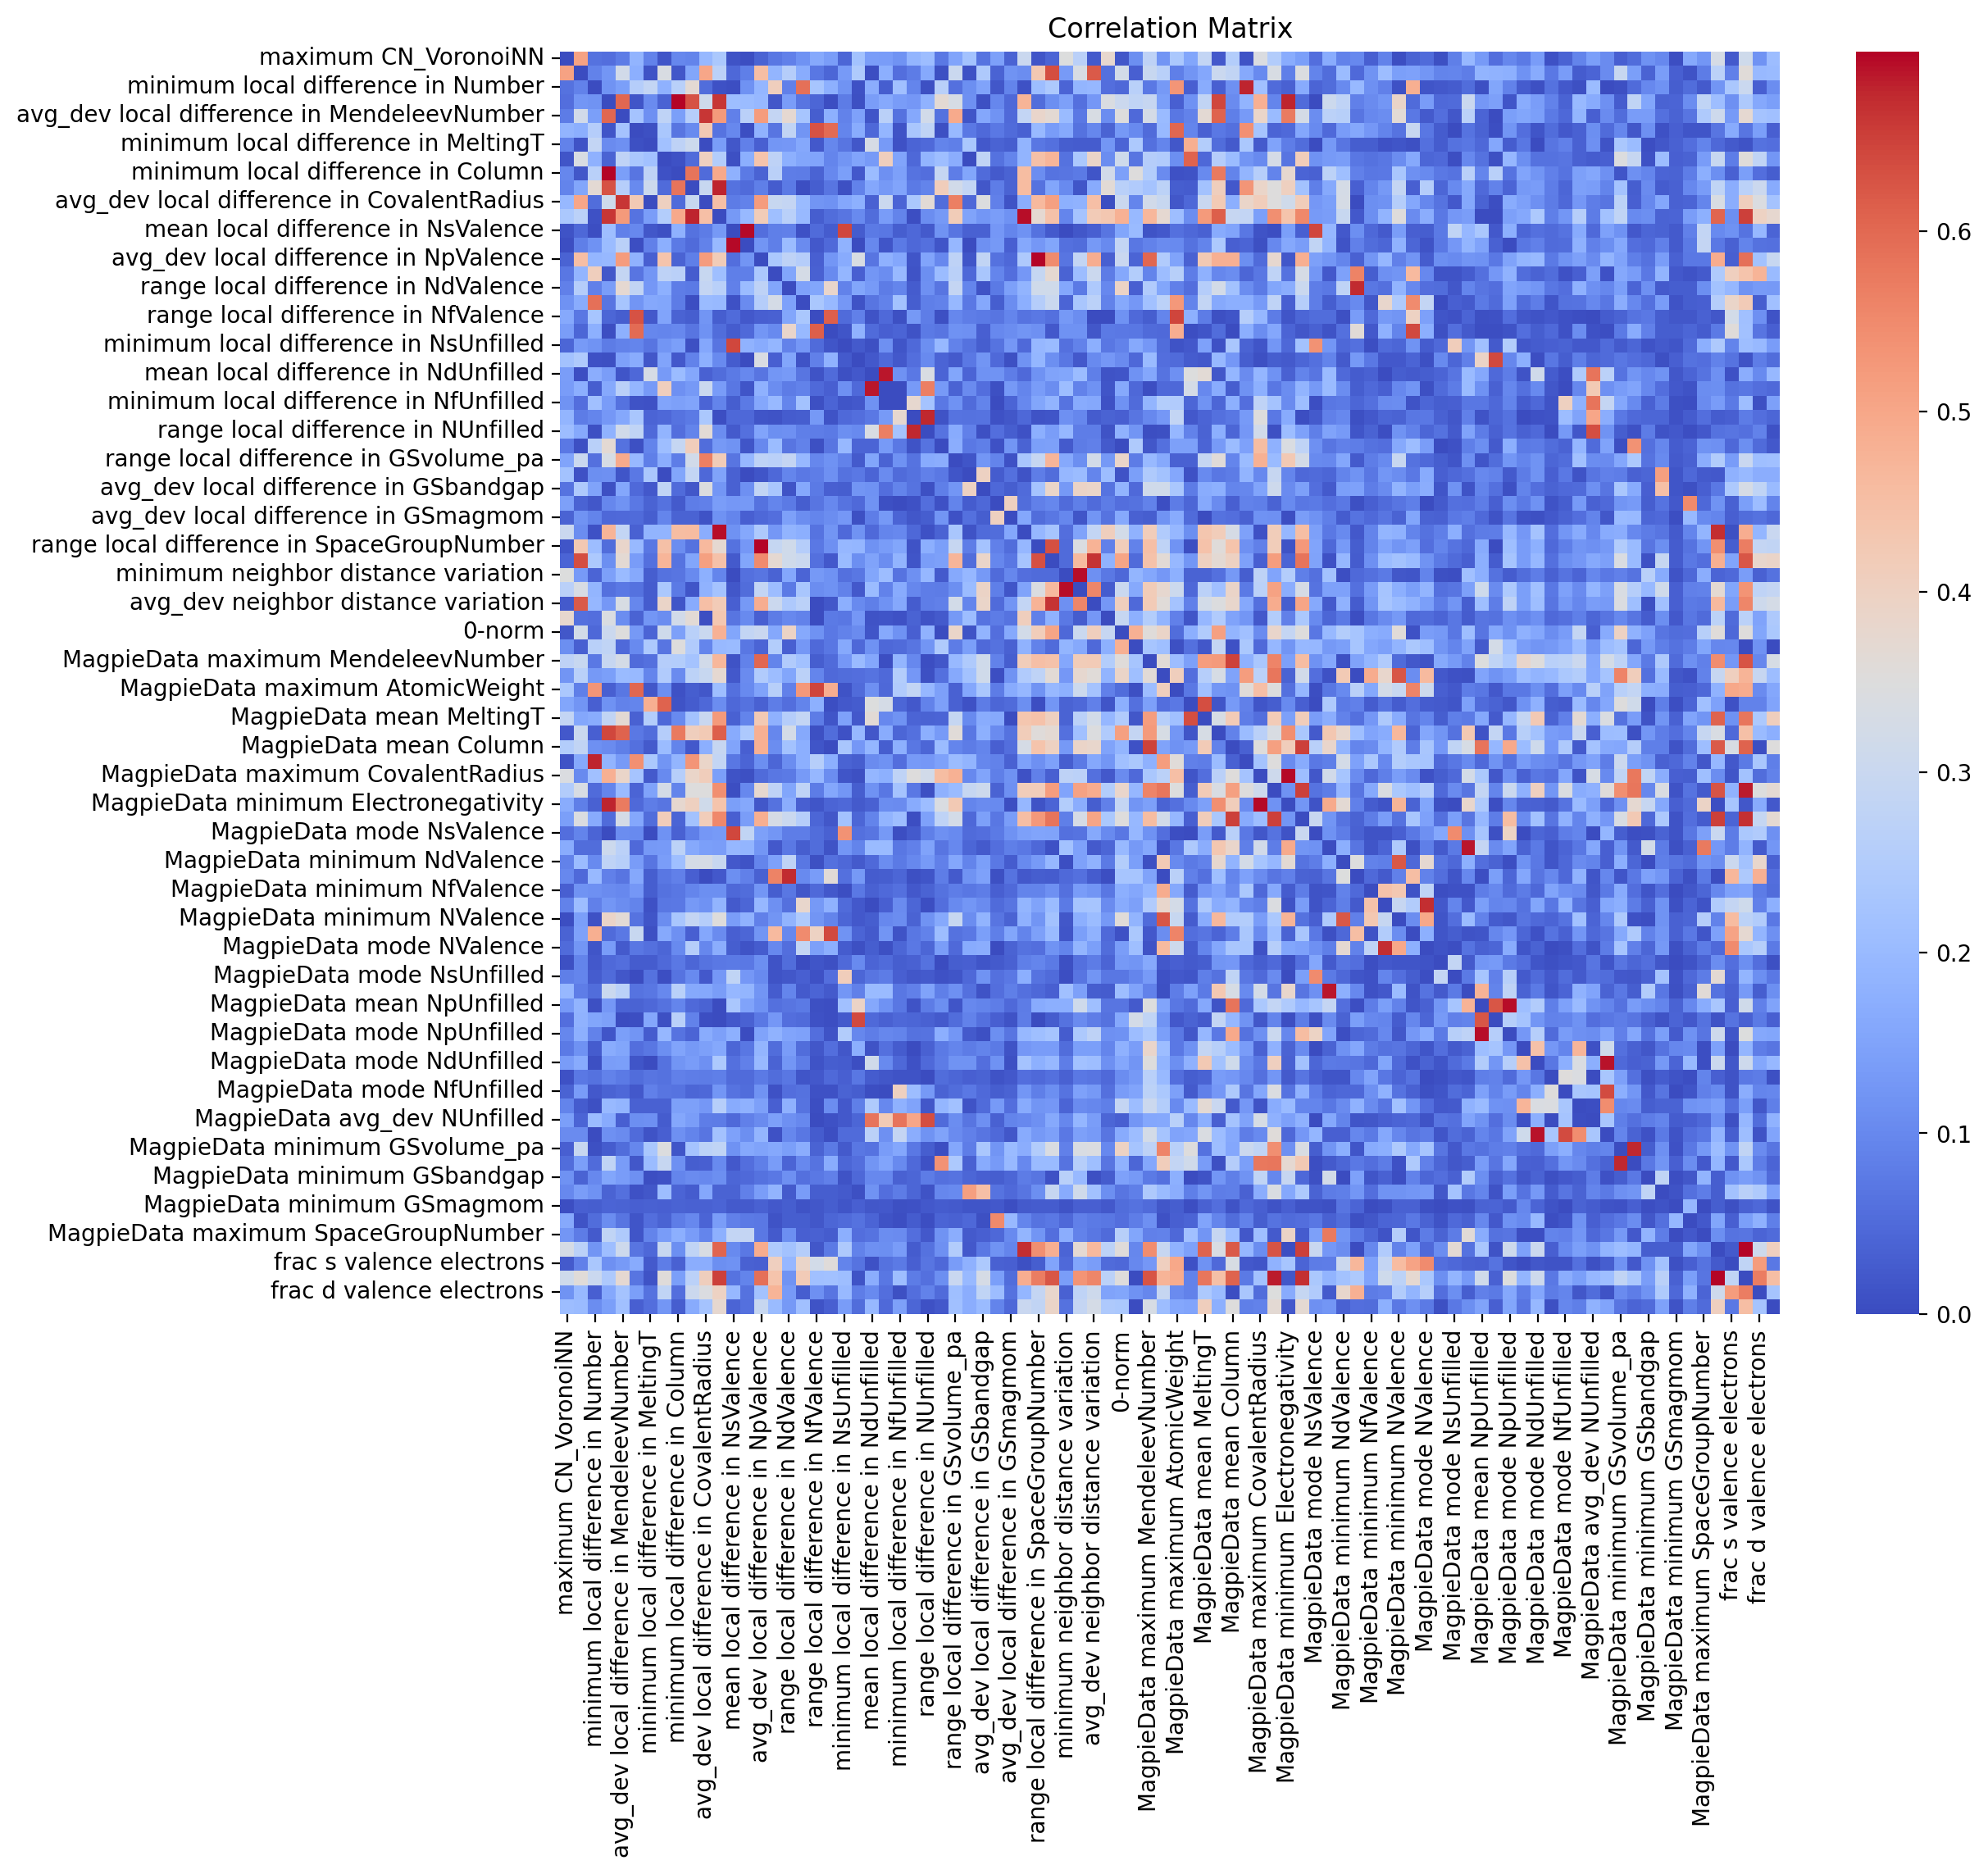

In [10]:
# plot the correlation matrix
plt.figure(figsize=(12,10))
sns.heatmap(corr, cmap='coolwarm', annot=False, fmt=".2f")
plt.title('Correlation Matrix')
plt.show()


In [11]:
count

,Count,Max,Mean
MagpieData minimum GSmagmom,0,0.193656,0.026634
MagpieData minimum NsUnfilled,0,0.286454,0.052209
MagpieData minimum GSbandgap,0,0.322432,0.080148
MagpieData minimum NfUnfilled,0,0.355241,0.066195
avg_dev local difference in GSmagmom,0,0.403748,0.072522
...,...,...,...
frac p valence electrons,0,0.697468,0.271703
range local difference in SpaceGroupNumber,0,0.698887,0.192973
avg_dev local difference in NpValence,0,0.698887,0.194239
minimum local difference in Column,0,0.699706,0.141164


In [12]:
# only keep the feautres in col2keep
X = X[col2keep]
# save X into a csv file
X.to_csv('X_formation_energy_non_highly_correlated.csv')

In [13]:
X

,MagpieData mode NpUnfilled,MagpieData mean Column,MagpieData maximum SpaceGroupNumber,avg_dev local difference in CovalentRadius,minimum local difference in Column,avg_dev local difference in NsValence,avg_dev local difference in GSmagmom,avg_dev local difference in MeltingT,avg_dev local difference in GSbandgap,range local difference in NUnfilled,...,MagpieData avg_dev NUnfilled,MagpieData minimum AtomicWeight,MagpieData maximum MendeleevNumber,avg_dev local difference in NValence,mean local difference in NdUnfilled,MagpieData minimum NUnfilled,MagpieData mode Electronegativity,avg_dev neighbor distance variation,MagpieData maximum CovalentRadius,minimum local difference in CovalentRadius
jid,,,,,,,,,,,,,,,,,,,,,
JVASP-90856,0.0,11.000000,227.0,9.730249,2.606183,0.193603,0.000005,202.832719,0.139541,3.214654e+00,...,2.000000,28.085500,84.0,2.625400,3.954813,1.0,1.54,3.278103e-03,160.0,9.252572
JVASP-86097,5.0,11.571429,194.0,19.976881,2.321363,0.000000,0.000000,122.635856,0.281896,7.552988e-01,...,0.244898,10.811000,72.0,1.664740,0.000000,4.0,2.04,5.467109e-02,192.0,25.070720
JVASP-64906,0.0,5.000000,194.0,0.500000,3.895137,0.250000,0.000000,174.750000,0.000000,1.332268e-15,...,2.000000,9.012182,67.0,3.500000,2.447568,0.0,1.57,6.028164e-17,146.0,31.757853
JVASP-98225,0.0,8.000000,229.0,1.528927,8.792858,0.027799,0.000000,5.778510,0.000000,1.994501e-01,...,1.000000,39.098300,86.0,0.778363,0.000000,1.0,0.82,8.556663e-03,203.0,34.543371
JVASP-10,2.0,12.333333,229.0,7.657251,3.913647,0.000000,0.000000,391.912018,0.185398,2.610426e+00,...,2.222222,50.941500,89.0,2.552417,3.708702,2.0,2.55,3.230997e-02,153.0,11.740942
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
JVASP-156020,0.0,9.800000,225.0,14.515769,4.447399,0.155090,0.000000,114.551645,0.000000,3.194559e+00,...,1.760000,102.905500,81.0,2.281432,4.282199,3.0,2.28,3.388106e-02,215.0,22.253880
JVASP-156398,0.0,9.333333,194.0,9.002206,5.000000,0.000000,0.000000,96.172564,0.000000,2.556291e+00,...,3.777778,65.380000,76.0,2.805985,0.000000,0.0,1.13,3.088369e-02,203.0,43.088303
JVASP-156099,3.0,11.600000,229.0,15.511391,3.533003,0.000000,0.000000,98.688854,0.000000,1.909640e+00,...,1.440000,114.818000,86.0,3.220581,0.000000,0.0,1.78,2.580265e-02,215.0,18.929661


In [14]:
# Split the dataset into train, test, and validation sets
# X_train is used for 5-fold cross validation of the model and then subsequent training of the model
# X_test is a 10% holdout set for final model testing
# X_validation is for baseline model validation post-training
# X should not be getting fed to the function

def split_data(X, y, test_size=0.2, val_size=0.5, random_state=random_state):
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=test_size, random_state=random_state)
    X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=val_size, random_state=random_state)
    return X_train, X_test, X_val, y_train, y_test, y_val

# Function to train, cross-validate, and evaluate a model
def evaluate_model(model, X_train, X_test, y_train, y_test, cv_splits=5, random_state=random_state, feature_importance_threshold=0.90):

    # Perform cross-validation
    kf = KFold(n_splits=cv_splits, shuffle=True, random_state=random_state)
    cv_scores = cross_val_score(model, X_train, y_train, cv=kf, scoring='neg_mean_squared_error')

    # Fit the model and make predictions
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Model evaluations
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    cv_mse = -np.mean(cv_scores)

    # Print evaluation metrics
    print(f'Model: {model.__class__.__name__}')
    print('Mean Squared Error:', mse)
    print('R2:', r2)
    print('Mean Absolute Error:', mae)
    print('Mean Absolute Percentage Error:', mape)
    print('Cross-Validated MSE:', cv_mse)
    print('-' * 50)

    # Save evaluation metrics
    metrics = {
        'model': model.__class__.__name__,
        'mse': mse,
        'r2': r2,
        'mae': mae,
        'mape': mape,
        'cv_mse': cv_mse
    }

    # plot the predicted vs true labels
    plt.scatter(x=y_test, y=y_pred)
    plt.plot([min(y), max(y)], [min(y), max(y)], color='red')
    plt.xlabel('True Labels')
    plt.ylabel('Predicted Labels')
    plt.title('Predicted vs True Labels')
    # provide metrics for goodness of fit in the plot
    plt.text(0.1, 0.9, f'MSE: {mse:.2f}', ha='center', va='center', transform=plt.gca().transAxes)
    plt.text(0.1, 0.85, f'R2: {r2:.2f}', ha='center', va='center', transform=plt.gca().transAxes)
    plt.text(0.1, 0.8, f'MAE: {mae:.2f}', ha='center', va='center', transform=plt.gca().transAxes)
    plt.text(0.1, 0.75, f'MAPE: {mape:.2f}', ha='center', va='center', transform=plt.gca().transAxes)
    plt.text(0.1, 0.7, f'CV MSE: {cv_mse:.2f}', ha='center', va='center', transform=plt.gca().transAxes)
    plt.show()

    # calculate the feature importance based on Gini impurity method
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]
    plt.figure(figsize=(10, 6))
    plt.bar(range(X_train.shape[1]), importances[indices], align='center')
    plt.xticks(range(X_train.shape[1]), np.array(X_train.columns)[indices], rotation=90)
    plt.title('Feature Importance')
    plt.show()

    # select features based on the feature importance
    # Sort the feature importances in descending order and get the sorted indices
    sorted_indices = np.argsort(importances)[::-1]
    sorted_importances = importances[sorted_indices]

    # Calculate the cumulative sum of the sorted importances
    cumulative_importances = np.cumsum(sorted_importances)

    # Find the number of features that explain at least feature_importance_threshold of the importance
    num_features = np.argmax(cumulative_importances >= feature_importance_threshold) + 1

    # Get the selected features indices
    selected_indices = sorted_indices[:num_features]

    # Select the corresponding columns from X_train
    # X_train is a DataFrame, and selected_indices contains the indices of selected features
    X_train_selected = X_train.iloc[:, selected_indices]
    
    return metrics, plt, sorted_importances, num_features, selected_indices, X_train_selected

In [15]:
# Example usage:
X_train, X_test, X_val, y_train, y_test, y_val = split_data(X, y, test_size=0.2, val_size=0.5, random_state=random_state)

# Define model parameters for RandomForestRegressor
rf_params = {
    'n_estimators': 200,
    'max_depth': None,
    'max_features': 0.4,
    'bootstrap': False,
    'random_state': random_state
}

# Define model parameters for XGBRegressor
xgb_params = {
    'n_estimators': 400,
    'max_depth': 10,
    'learning_rate': 0.05,
    'random_state': random_state,
    'subsample': 0.9,
    'colsample_bytree': 0.5
}

In [16]:
X_train.shape, X_test.shape, X_val.shape

((57256, 88), (7157, 88), (7158, 88))

In [ ]:
# Initialize models
model_rf = RandomForestRegressor(**rf_params)
model_xgb = XGBRegressor(**xgb_params)

# Evaluate models and save metrics
metrics_rf = evaluate_model(model_rf, X_train, X_test, y_train, y_test, cv_splits=5, random_state=random_state)
metrics_xgb = evaluate_model(model_xgb, X_train, X_test, y_train, y_test, cv_splits=5, random_state=random_state)

# Store metrics in a dictionary
all_metrics = {
    'RandomForest': metrics_rf,
    'XGBoost': metrics_xgb
}

# Print or save the metrics as needed
print(all_metrics)

# Save the metrics
pd.DataFrame(all_metrics).to_csv('results_model_metrics.csv')


In [18]:
all_metrics.keys()

dict_keys(['RandomForest', 'XGBoost'])

In [19]:
# Save the selected feature names
selected_feature_xgb =all_metrics["XGBoost"][-1].columns.tolist()
selected_feature_xgb

# Save the selected feature names
selected_feature_rf =all_metrics["RandomForest"][-1].columns.tolist()
selected_feature_rf

# find the union of the selected features from both models
union_features = list(set(selected_feature_xgb).union(set(selected_feature_rf)))
len(union_features)

47

# select union features from two models and save it

In [20]:
# extarct the union features from the X, here union_features is a list
X_union = X[union_features]
X_union

,mean neighbor distance variation,MagpieData mode NsValence,MagpieData maximum SpaceGroupNumber,MagpieData maximum MendeleevNumber,avg_dev local difference in CovalentRadius,compound possible,MagpieData range NdValence,MagpieData mean Column,mean local difference in Electronegativity,minimum local difference in GSbandgap,...,range local difference in SpaceGroupNumber,maximum CN_VoronoiNN,MagpieData range Column,MagpieData mean MeltingT,MagpieData maximum MeltingT,MagpieData mode NUnfilled,frac p valence electrons,MagpieData minimum GSbandgap,minimum local difference in Column,MagpieData mode NpUnfilled
jid,,,,,,,,,,,,,,,,,,,,,
JVASP-90856,0.064699,1.0,227.0,84.0,9.730249,False,10.0,11.000000,0.316376,0.000000,...,23.850694,10.623333,11.0,1518.942500,1941.0,1.0,0.147059,0.0,2.606183,0.0
JVASP-86097,0.200279,2.0,194.0,72.0,19.976881,False,0.0,11.571429,0.278830,0.353776,...,21.148365,24.598746,10.0,2253.285714,2348.0,5.0,0.200000,0.0,2.321363,5.0
JVASP-64906,0.011565,2.0,194.0,67.0,0.500000,False,7.0,5.000000,0.408989,0.000000,...,0.000000,11.982697,6.0,2258.250000,3306.0,0.0,0.000000,0.0,3.895137,0.0
JVASP-98225,0.071601,1.0,229.0,86.0,1.528927,False,10.0,8.000000,0.827830,0.000000,...,21.640334,12.260669,14.0,440.465000,544.4,1.0,0.100000,0.0,8.792858,0.0
JVASP-10,0.119720,2.0,229.0,89.0,7.657251,False,7.0,12.333333,0.487429,0.284273,...,112.248335,11.168806,11.0,1057.000000,2183.0,2.0,0.216216,0.0,3.913647,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
JVASP-156020,0.112164,1.0,225.0,81.0,14.515769,False,9.0,9.800000,0.531222,0.000000,...,0.000000,18.191019,11.0,1399.644000,2237.0,3.0,0.051948,0.0,4.447399,0.0
JVASP-156398,0.046326,2.0,194.0,76.0,9.002206,False,10.0,9.333333,0.357266,0.000000,...,0.000000,9.971808,10.0,824.560000,1204.0,0.0,0.022727,0.0,5.000000,0.0
JVASP-156099,0.109214,2.0,229.0,86.0,15.511391,False,10.0,11.600000,0.522216,0.000000,...,76.048553,16.143290,13.0,589.660000,1000.0,3.0,0.093023,0.0,3.533003,3.0


In [21]:
X_union.columns

Index(['mean neighbor distance variation', 'MagpieData mode NsValence',
       'MagpieData maximum SpaceGroupNumber',
       'MagpieData maximum MendeleevNumber',
       'avg_dev local difference in CovalentRadius', 'compound possible',
       'MagpieData range NdValence', 'MagpieData mean Column',
       'mean local difference in Electronegativity',
       'minimum local difference in GSbandgap', 'frac d valence electrons',
       'MagpieData mean NpUnfilled', 'MagpieData mode Electronegativity',
       'minimum local difference in GSvolume_pa',
       'range local difference in NfUnfilled',
       'minimum local difference in MeltingT',
       'MagpieData mode SpaceGroupNumber', 'MagpieData minimum NUnfilled',
       'avg_dev CN_VoronoiNN', 'MagpieData minimum Electronegativity',
       'avg_dev local difference in MendeleevNumber',
       'minimum local difference in SpaceGroupNumber',
       'range local difference in NUnfilled',
       'mean local difference in MendeleevNumber',
 

In [22]:
# save X_union into a csv file
X_union.to_csv('X_formation_energy_union_features.csv')

In [23]:
# load the data
X_union = pd.read_csv('X_formation_energy_union_features.csv',index_col=0)

In [24]:
X_union

,mean neighbor distance variation,MagpieData mode NsValence,MagpieData maximum SpaceGroupNumber,MagpieData maximum MendeleevNumber,avg_dev local difference in CovalentRadius,compound possible,MagpieData range NdValence,MagpieData mean Column,mean local difference in Electronegativity,minimum local difference in GSbandgap,...,range local difference in SpaceGroupNumber,maximum CN_VoronoiNN,MagpieData range Column,MagpieData mean MeltingT,MagpieData maximum MeltingT,MagpieData mode NUnfilled,frac p valence electrons,MagpieData minimum GSbandgap,minimum local difference in Column,MagpieData mode NpUnfilled
jid,,,,,,,,,,,,,,,,,,,,,
JVASP-90856,0.064699,1.0,227.0,84.0,9.730249,False,10.0,11.000000,0.316376,0.000000,...,23.850694,10.623333,11.0,1518.942500,1941.0,1.0,0.147059,0.0,2.606183,0.0
JVASP-86097,0.200279,2.0,194.0,72.0,19.976881,False,0.0,11.571429,0.278830,0.353776,...,21.148365,24.598746,10.0,2253.285714,2348.0,5.0,0.200000,0.0,2.321363,5.0
JVASP-64906,0.011565,2.0,194.0,67.0,0.500000,False,7.0,5.000000,0.408989,0.000000,...,0.000000,11.982697,6.0,2258.250000,3306.0,0.0,0.000000,0.0,3.895137,0.0
JVASP-98225,0.071601,1.0,229.0,86.0,1.528927,False,10.0,8.000000,0.827830,0.000000,...,21.640334,12.260669,14.0,440.465000,544.4,1.0,0.100000,0.0,8.792858,0.0
JVASP-10,0.119720,2.0,229.0,89.0,7.657251,False,7.0,12.333333,0.487429,0.284273,...,112.248335,11.168806,11.0,1057.000000,2183.0,2.0,0.216216,0.0,3.913647,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
JVASP-156020,0.112164,1.0,225.0,81.0,14.515769,False,9.0,9.800000,0.531222,0.000000,...,0.000000,18.191019,11.0,1399.644000,2237.0,3.0,0.051948,0.0,4.447399,0.0
JVASP-156398,0.046326,2.0,194.0,76.0,9.002206,False,10.0,9.333333,0.357266,0.000000,...,0.000000,9.971808,10.0,824.560000,1204.0,0.0,0.022727,0.0,5.000000,0.0
JVASP-156099,0.109214,2.0,229.0,86.0,15.511391,False,10.0,11.600000,0.522216,0.000000,...,76.048553,16.143290,13.0,589.660000,1000.0,3.0,0.093023,0.0,3.533003,3.0


In [25]:
# print the union feature columns
X_union.columns


Index(['mean neighbor distance variation', 'MagpieData mode NsValence',
       'MagpieData maximum SpaceGroupNumber',
       'MagpieData maximum MendeleevNumber',
       'avg_dev local difference in CovalentRadius', 'compound possible',
       'MagpieData range NdValence', 'MagpieData mean Column',
       'mean local difference in Electronegativity',
       'minimum local difference in GSbandgap', 'frac d valence electrons',
       'MagpieData mean NpUnfilled', 'MagpieData mode Electronegativity',
       'minimum local difference in GSvolume_pa',
       'range local difference in NfUnfilled',
       'minimum local difference in MeltingT',
       'MagpieData mode SpaceGroupNumber', 'MagpieData minimum NUnfilled',
       'avg_dev CN_VoronoiNN', 'MagpieData minimum Electronegativity',
       'avg_dev local difference in MendeleevNumber',
       'minimum local difference in SpaceGroupNumber',
       'range local difference in NUnfilled',
       'mean local difference in MendeleevNumber',
 

# Retrain the model to check the performance changes if only use union features

# need to retrain the hyperparamters since feature set changes

In [26]:
# Example usage:
X_train, X_test, X_val, y_train, y_test, y_val = split_data(X_union, y, test_size=0.2, val_size=0.5, random_state=random_state)

# Define model parameters for RandomForestRegressor
rf_params = {
    'n_estimators': 200,
    'max_depth': None,
    'max_features': 0.4,
    'bootstrap': False,
    'random_state': random_state
}

# Define model parameters for XGBRegressor
xgb_params = {
    'n_estimators': 400,
    'max_depth': 10,
    'learning_rate': 0.05,
    'random_state': random_state,
    'subsample': 0.9,
    'colsample_bytree': 0.5
}


Model: RandomForestRegressor
Mean Squared Error: 0.038443511215156545
R2: 0.9668039806267524
Mean Absolute Error: 0.09077280270624166
Mean Absolute Percentage Error: 145321192529.2601
Cross-Validated MSE: 0.042257842070809994
--------------------------------------------------


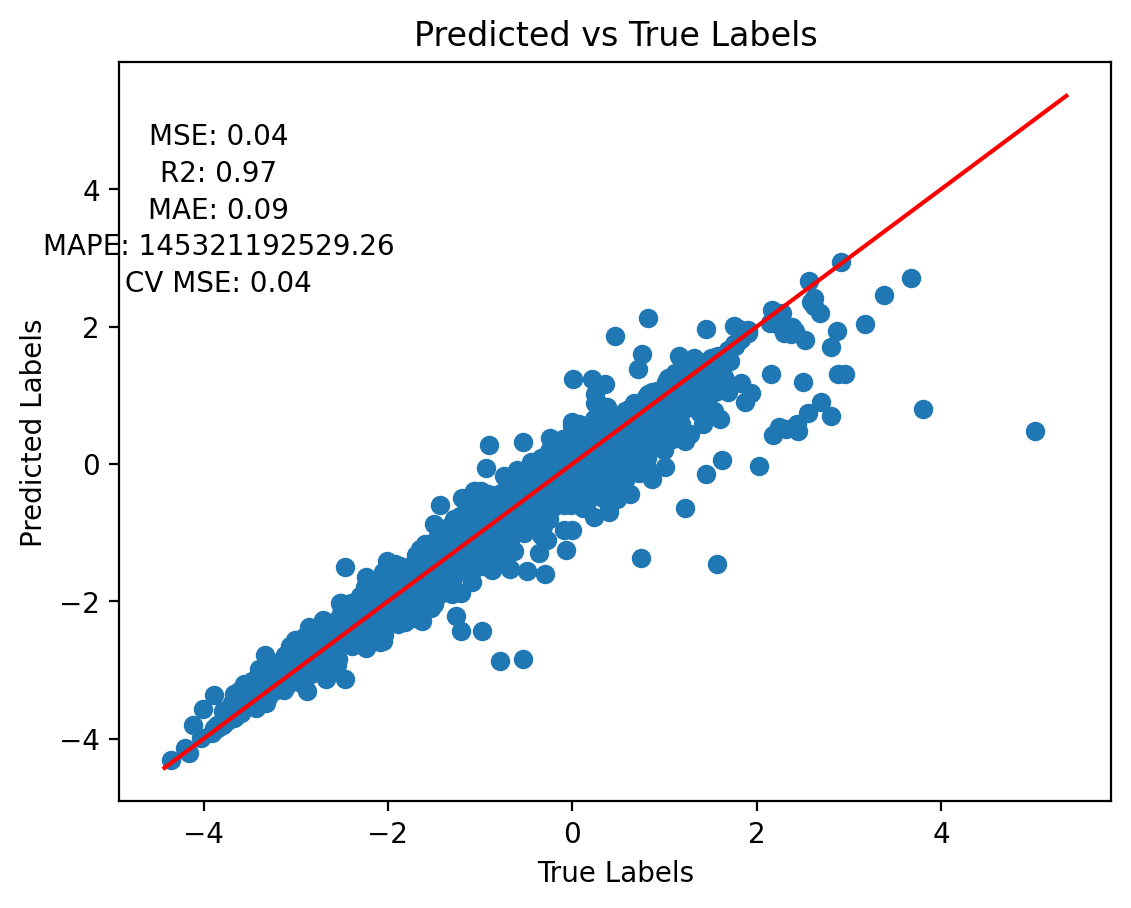

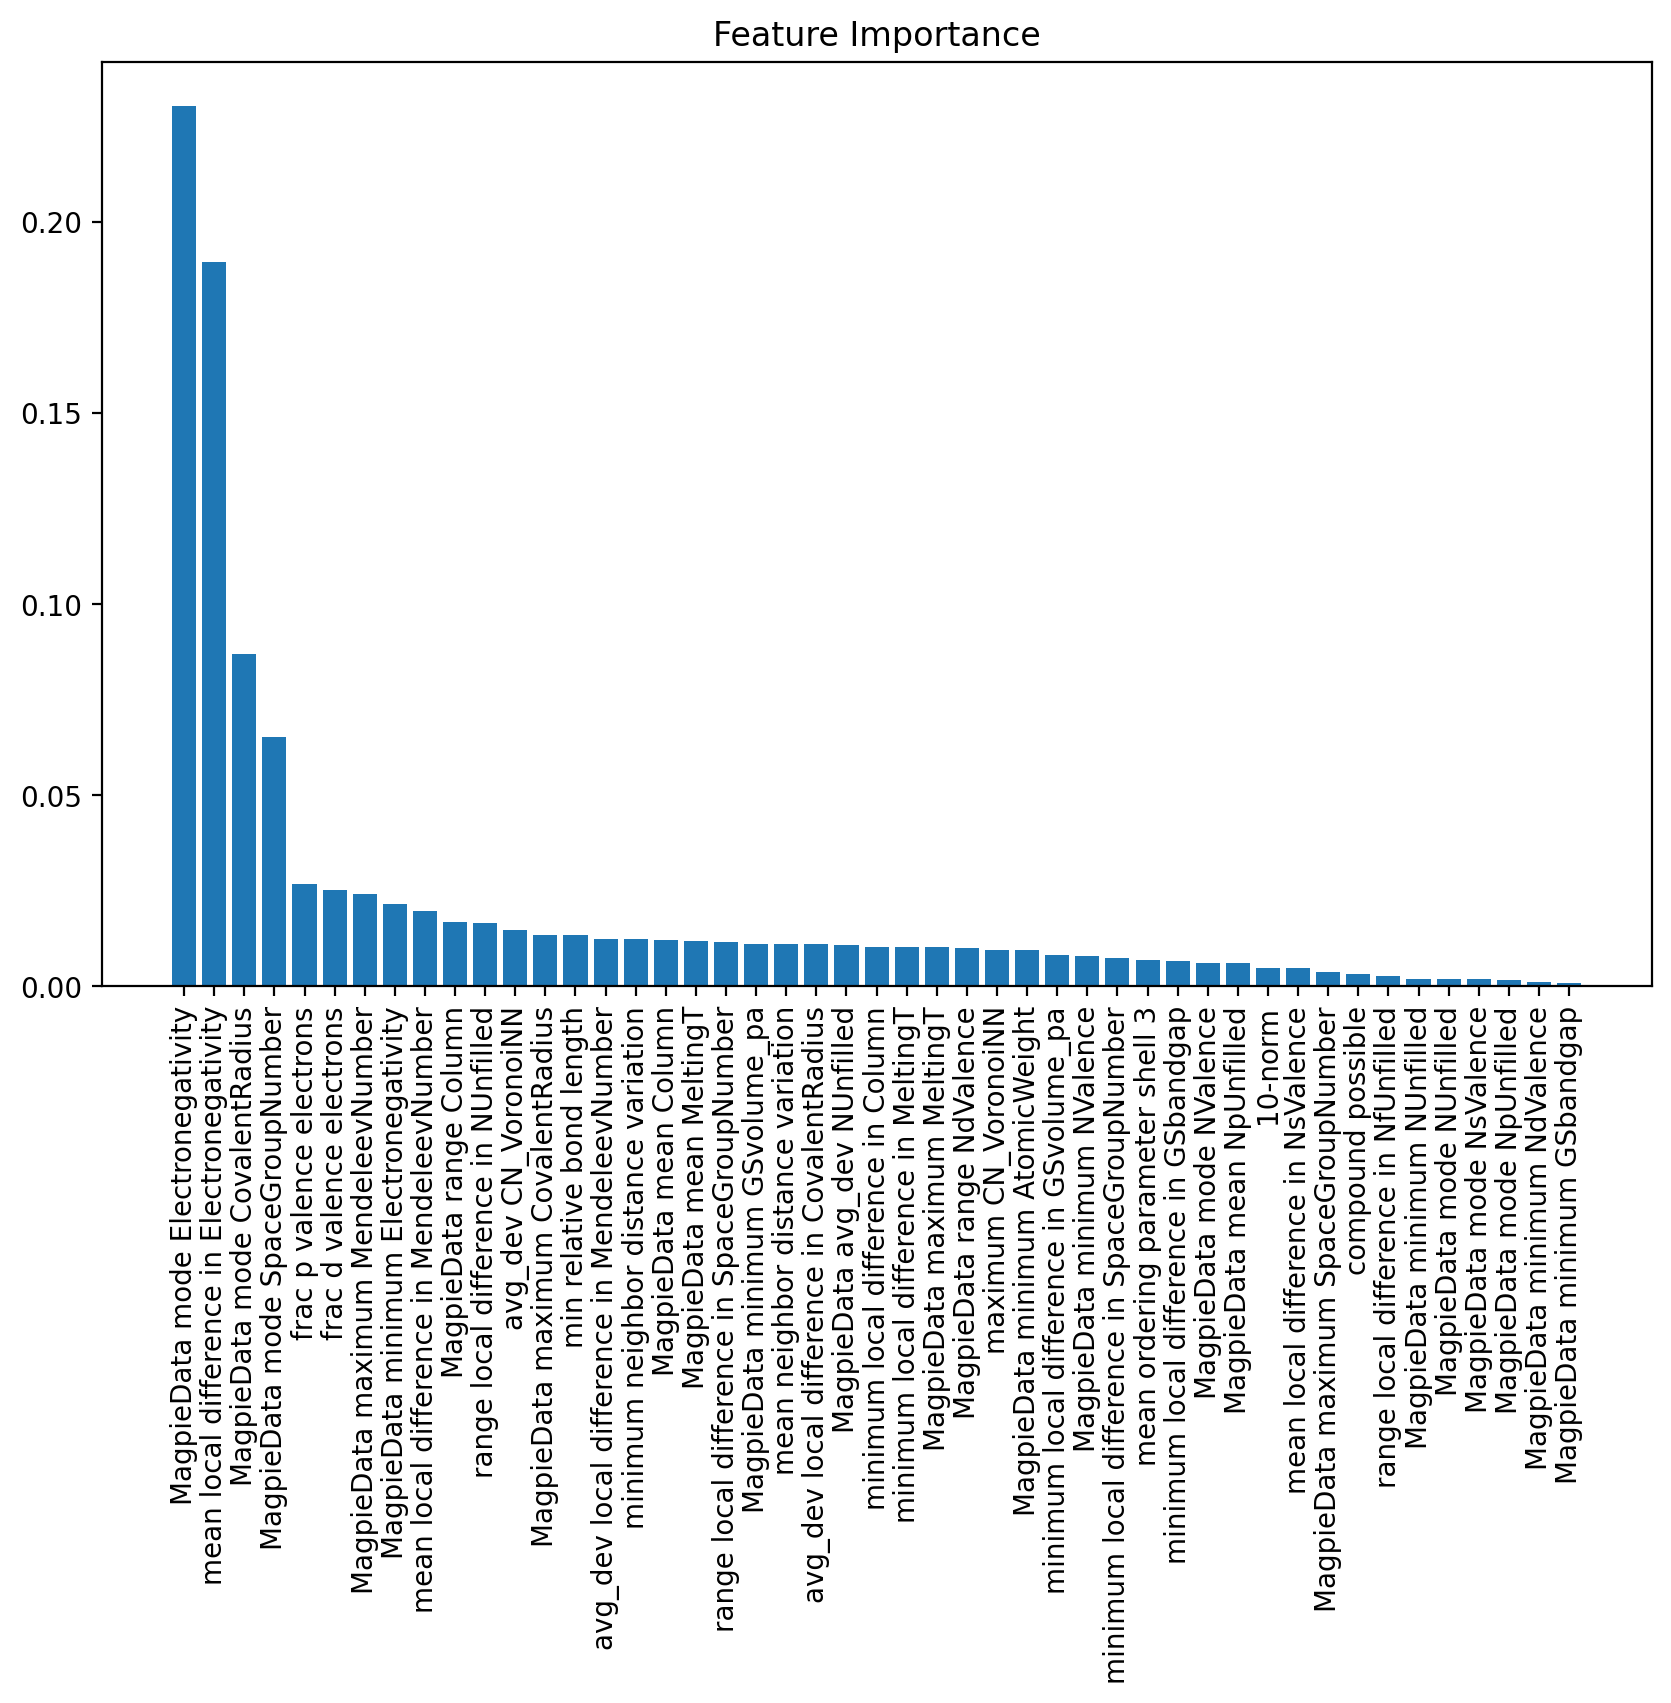

Model: XGBRegressor
Mean Squared Error: 0.034273624370939816
R2: 0.9704046830623378
Mean Absolute Error: 0.09180600048644064
Mean Absolute Percentage Error: 346655530678.7259
Cross-Validated MSE: 0.03601365333824023
--------------------------------------------------


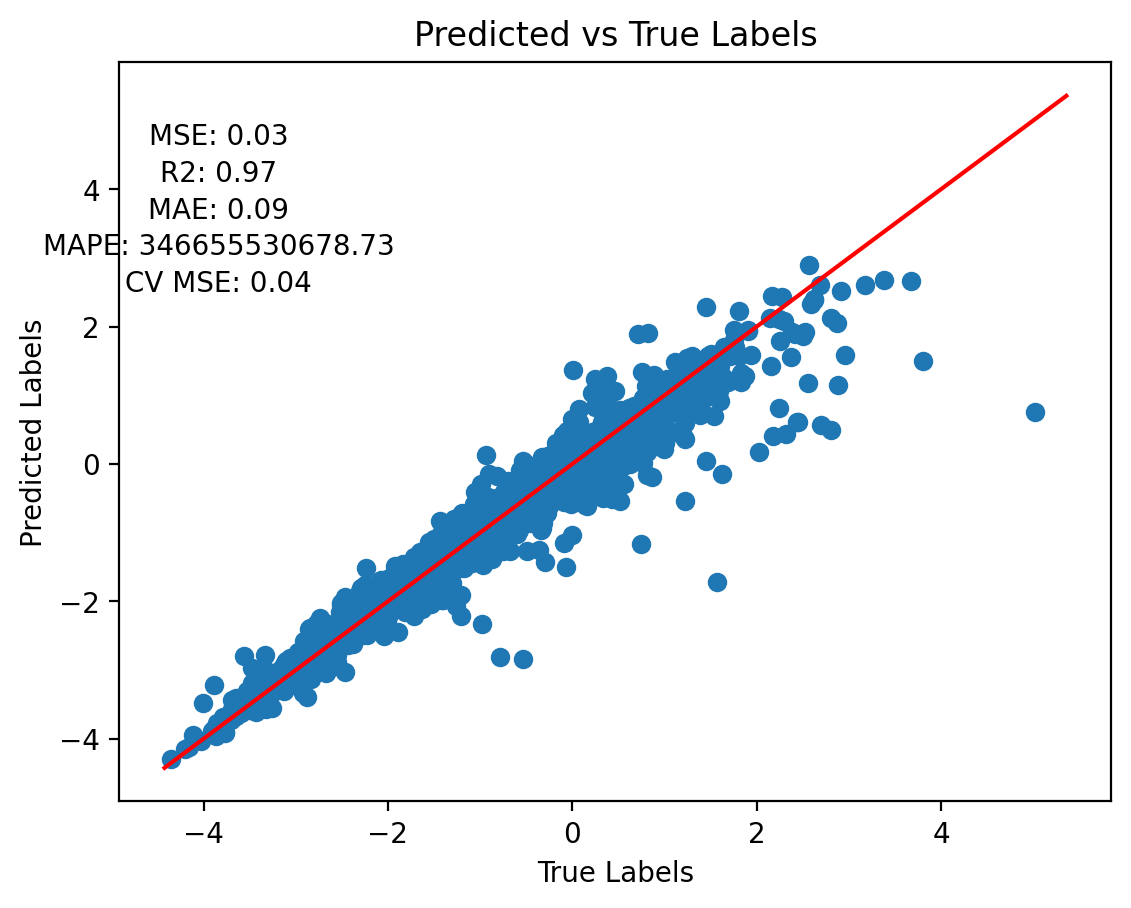

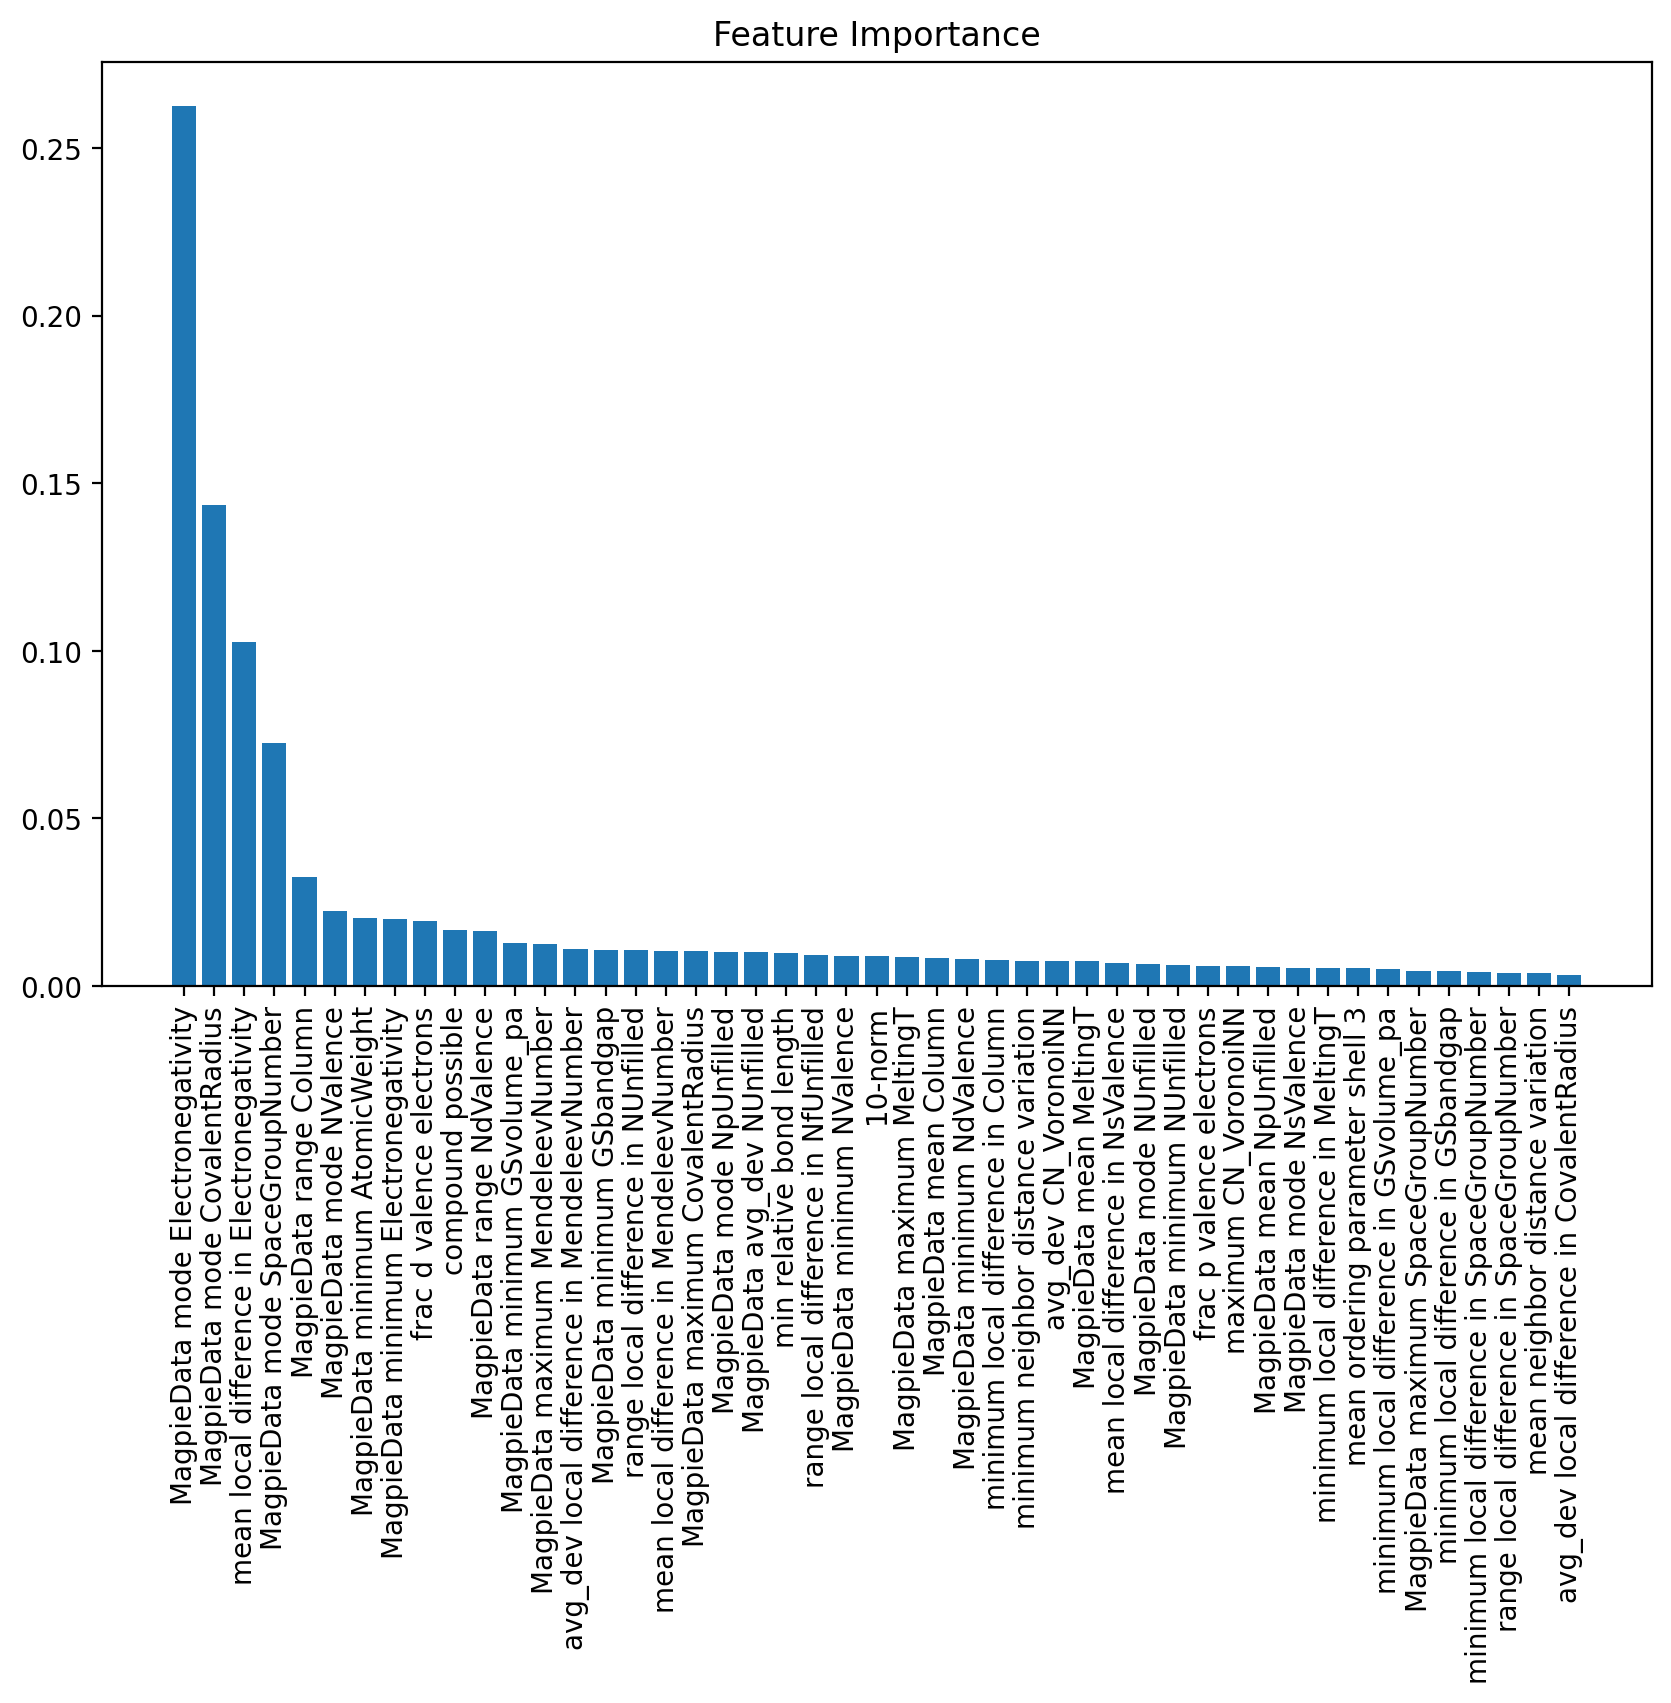

{'RandomForest_retrain': ({'model': 'RandomForestRegressor', 'mse': 0.037881299371651585, 'r2': 0.9672894512473835, 'mae': 0.09024450654687058, 'mape': 142540218186.15945, 'cv_mse': 0.041328169956663656}, <module 'matplotlib.pyplot' from '/Users/sara/.pyenv/versions/yao_project/lib/python3.10/site-packages/matplotlib/pyplot.py'>, array([2.20283809e-01, 2.14642697e-01, 7.91689994e-02, 5.50170117e-02,
       2.41456718e-02, 2.39956454e-02, 2.22189713e-02, 1.99938627e-02,
       1.53388567e-02, 1.38718673e-02, 1.37042115e-02, 1.33809915e-02,
       1.33523972e-02, 1.22542535e-02, 1.14759882e-02, 9.54568283e-03,
       9.48533629e-03, 9.33398963e-03, 9.33301933e-03, 8.97015984e-03,
       8.81744383e-03, 8.55795699e-03, 8.46238714e-03, 8.40111445e-03,
       8.15731365e-03, 8.13984375e-03, 8.04750506e-03, 7.85262458e-03,
       7.64852114e-03, 6.38719048e-03, 6.12525212e-03, 6.11397899e-03,
       5.73115459e-03, 5.17940057e-03, 4.98791476e-03, 4.77478494e-03,
       4.53376707e-03, 4.3941

In [27]:
# Initialize models
model_rf_retrain = RandomForestRegressor(**rf_params)
model_xgb_retrain = XGBRegressor(**xgb_params)

# Evaluate models and save metrics
metrics_rf_retrain = evaluate_model(model_rf_retrain, X_train, X_test, y_train, y_test, cv_splits=5, random_state=random_state)
metrics_xgb_retrain = evaluate_model(model_xgb_retrain, X_train, X_test, y_train, y_test, cv_splits=5, random_state=random_state)

# Store metrics in a dictionary
all_metrics = {
    'RandomForest_retrain': metrics_rf,
    'XGBoost_retrain': metrics_xgb
}

# Print or save the metrics as needed
print(all_metrics)

# save the metrics
pd.DataFrame(all_metrics).to_csv('results_model_metrics_union_features.csv')

# check the MAPE values

In [31]:
# from the feature imporanace calculation, print the top 10 most important features names
top_10_features = X_union.columns[np.argsort(all_metrics["XGBoost_retrain"][-2])[::-1]][:10]
top_10_features
    

Index(['MagpieData mode SpaceGroupNumber', 'MagpieData mode NValence',
       'minimum local difference in SpaceGroupNumber',
       'frac d valence electrons', 'MagpieData mode Electronegativity',
       'compound possible', 'MagpieData mode NsValence',
       'range local difference in NfUnfilled', 'MagpieData mean Column',
       '10-norm'],
      dtype='object')

In [29]:
sorted_importances

array([2.20283809e-01, 2.14642697e-01, 7.91689994e-02, 5.50170117e-02,
       2.41456718e-02, 2.39956454e-02, 2.22189713e-02, 1.99938627e-02,
       1.53388567e-02, 1.38718673e-02, 1.37042115e-02, 1.33809915e-02,
       1.33523972e-02, 1.22542535e-02, 1.14759882e-02, 9.54568283e-03,
       9.48533629e-03, 9.33398963e-03, 9.33301933e-03, 8.97015984e-03,
       8.81744383e-03, 8.55795699e-03, 8.46238714e-03, 8.40111445e-03,
       8.15731365e-03, 8.13984375e-03, 8.04750506e-03, 7.85262458e-03,
       7.64852114e-03, 6.38719048e-03, 6.12525212e-03, 6.11397899e-03,
       5.73115459e-03, 5.17940057e-03, 4.98791476e-03, 4.77478494e-03,
       4.53376707e-03, 4.39416112e-03, 4.04243271e-03, 4.01543268e-03,
       3.93761738e-03, 3.77004590e-03, 3.53149748e-03, 3.41403785e-03,
       3.26041577e-03, 3.06495043e-03, 3.06479957e-03, 3.00798556e-03,
       2.88128852e-03, 2.80284797e-03, 2.68508627e-03, 2.64144411e-03,
       2.63100390e-03, 2.28764824e-03, 2.21546588e-03, 2.20771927e-03,
      